# 1. Introduction

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.1 Objectives</b></p>
</div>

In this notebook, we'll be covering what a **Gaussian Mixture Model** (GMM) is and **implementing it from scratch**. I will be placing particular emphasis on building **intuition through examples** in 1 dimension and later generalising the equations to $d$ dimensions. 

The notebook is structured as follows:

* Probability/ Statistics review
* Gaussian Mixture **examples**
* EM algorithm in **1 dimension**
* EM algorithm in **d dimensions**

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.2 History</b></p>
</div>

The idea of using **Gaussian mixtures** was popularised by Duda and Hart in their seminal 1973 text, '[Pattern Classification and Scene Analysis](https://www.semanticscholar.org/paper/Pattern-classification-and-scene-analysis-Duda-Hart/b07ce649d6f6eb636872527104b0209d3edc8188)'. However, it was not until 1977 that the **Expectation-Maximisation (EM)** was presented by Dempster, Laird and Rubin in their paper, '[Maximum Likelihood from Incomplete Data Via the EM Algorithm](https://rss.onlinelibrary.wiley.com/doi/epdf/10.1111/j.2517-6161.1977.tb01600.x)'. 

As we will see later, the EM algorithm is the **learning algorithm** behind a Gaussian Mixture Model (GMM), i.e. it solves the inverse problem by finding the **parameters** of the model.

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.3 Motivation</b></p>
</div>
 
You might be familiar with **k-Means**, which is a clustering algorithm that identifies k centroids and **allocates** data points based on the **nearest centroid**. Whilst k-Means is a **simple and fast** algorithm, it's main drawback is that it produces **spherical clusters**, which can model the data poorly. 

This is where **GMMs** come in. We will see that they produce clusters with **Gaussian distributions**, which are much more **flexible, and reflective** of real-life data.

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.4 Libraries</b></p>
</div>

In [1]:
# Core
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from itertools import combinations
import math
import statistics
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import chi2
from scipy.stats import poisson
from scipy.stats import multivariate_normal
import time
from datetime import datetime
import matplotlib.dates as mdates
import plotly.express as px
from termcolor import colored
import warnings
warnings.filterwarnings("ignore")

# Sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

# UMAP
import umap
import umap.plot

# 2. Prerequisites

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.1 Normal distribution in 1 dimension</b></p>
</div>

The **normal distribution** (or Gaussian distribution) is a continuous probability distribution characterised by its **bell shape**. It has the **probability density function** given by

$$
f_{\mathcal{N}(\mu, \sigma^2)} (x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left(-\frac{(x-\mu)^2}{2 \sigma^2} \right)
$$

where

* $x$ is a real number
* $\mu$ is the mean
* $\sigma$ is the standard deviation
* $\pi=3.141592653 \ldots$.

<center>
<img src="https://cdn.kastatic.org/ka-perseus-graphie/191a8f604b04f7b6e4a80d04db881c12798856f7.svg" width="400">
</center>

The normal distribution appears all the time in real life due to the **Central Limit Theorem**. This states that under certain conditions, the averages of many samples of a random variable **converge** to a normal distribution.

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.2 Normal distribution in d dimensions</b></p>
</div>

The **multivariate normal distribution** is the generalisation of the normal disitribution to $d$ dimensions. This time, the **probability density function** is given by

$$
f_{\mathcal{N}({\boldsymbol \mu}, {\boldsymbol \Sigma})} (\textbf{x}) = \frac{1}{\sqrt{(2 \pi)^d \det({\boldsymbol \Sigma})}} \exp \left(-\frac{(\textbf{x}-{\boldsymbol \mu})^T {\boldsymbol \Sigma}^{-1} (\textbf{x}-{\boldsymbol \mu})}{2} \right)
$$

where 

* $\textbf{x} = (x_1, \ldots, x_d)$ is a vector of length $d$
* ${\boldsymbol \mu} = (\mu_1, \ldots, \mu_d)$ is the mean vector
* ${\boldsymbol \Sigma}$ is the covariance matrix of size $d \times d$
* $\det({\boldsymbol \Sigma})$ is the determinant of the covariance matrix.

<center>
<img src="https://se.mathworks.com/help/examples/stats/win64/ComputeTheMultivariateNormalPdfExample_01.png" width="400">
</center>

The main difference to the univariate case, is that each feature/dimension can be **correlerated** with the other ones. These correlations are modelled by the **covariance matrix**, which allows for the density function to be **rotated** and **stretched** to model the data as well as possible.

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.3 Bayes' theorem</b></p>
</div>

**Bayes' theorem** is incredibly important. It allows us to calculate the **probability of an event** based on **prior knowledge** related to the event. In its simplest form, the theorem states that

$$
\mathbb{P}(A | B) = \frac{\mathbb{P}(B | A) \mathbb{P}(A)}{\mathbb{P}(B)}
$$

whenever the denominator is **well-defined** (i.e. not 0). In **Bayesian statistics** these terms are given technical names:

* $\mathbb{P}(A)$ is called the **prior**
* $\mathbb{P}(B | A)$ is called the **likelihood**
* $\mathbb{P}(A | B)$ is called the **posterior**
* $\mathbb{P}(B)$ is called the **evidence**.

<hr>

An **equivalent formula**, which we will use later, is given by 

$$
\mathbb{P}(A | B) = \frac{\mathbb{P}(B | A) \mathbb{P}(A)}{\mathbb{P}(B | A) \mathbb{P}(A)+\mathbb{P}(B | A^{c}) \mathbb{P}(A^{c})}
$$

where the event $A^{c}$ is the **complement** of $A$. This is derived by using the the **Law of Total Probability**. This formula is useful when you need to **compare two posterior distributions** and choose the most probable one. 

<hr>

The more **general version** of this formula, which we will also use, is given by

$$
\mathbb{P}(A_j | B) = \frac{\mathbb{P}(B | A_j) \mathbb{P}(A_j)}{\sum_{t} \mathbb{P}(B | A_t) \mathbb{P}(A_t)}.
$$

This is used when you need to **compare several posterior distributions** and choose the most probable one. 

# 3. Gaussian Mixtures

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.1 Definition</b></p>
</div>

A **Gaussian Mixture** is simply a combination (or mixture) of Gaussian distributions. Note that a Guassian distribution is the same as a **Normal** distribution and I will use these terms interchangeably. It is a **common** distribution that appears in **clustering** problems where the data is sampled randomly from several groups that each follow a normal distribution. 

<hr>

In **1 dimension**, the model is a weighted sum of **univariate** normal distributions:

$$
f_{GMM} (x) = \sum_{j=1}^{k} \pi_j f_{\mathcal{N}(\mu_j, \sigma_{j}^2)} (x)
$$

where 

* k = number of clusters
* x is a real number
* $f_{\mathcal{N}(\mu, \sigma^2)}$ is the density of a normal distribution with mean $\mu$ and variance $\sigma^2$
* $\pi = (\pi_1, ..., \pi_k)$ are the weights subject to

$$
0 \leq \pi_j \leq 1, \quad \sum_{j=1}^{k} \pi_j = 1.
$$

<hr>

In **d dimensions**, the model is a weighted sum of **multivariate** normal distributions:

$$
f_{GMM} (\textbf{x}) = \sum_{j=1}^{k} \pi_j f_{\mathcal{N}({\boldsymbol \mu}_j, {\boldsymbol \Sigma}_{j})} (\textbf{x})
$$

where

* $\textbf{x} = (x_1, \ldots, x_d)$ is now a vector of length $d$
* $f_{\mathcal{N}({\boldsymbol \mu}_j, {\boldsymbol \Sigma}_{j})}$ is the density of a **multivariate** normal distribution with mean vector ${\boldsymbol \mu}$ and covariance matrix ${\boldsymbol \Sigma}$
* $\pi = (\pi_1, ..., \pi_k)$ are the weights subject to the same conditions as before.

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.2 Example in 1D</b></p>
</div>

Suppose that every month for a year, you **survey random people** from the population and ask them whether they **approve** of the prime minister/president or not. I'm from the UK so we will use Boris Johnson as an example. As you might expect, people who **support** his party (the Conservatives) are **more likely** to approve of him, whilst people who support the main **opposition** party (Labour) are **less likely** to approve of him. The distribution produced is a Gaussian Mixture.

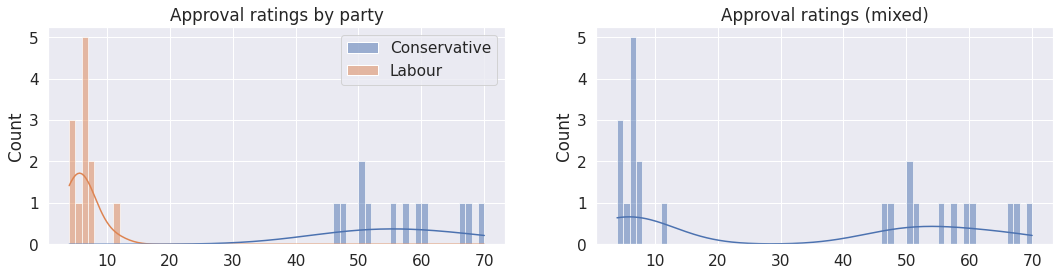

In [2]:
# Monthly approval ratings for Boris Johnson (dates: Aug 2021- July 2022, source: YouGov)
df_approval = pd.DataFrame({'Conservative': [67,70,66,57,47,46,50,60,59,55,51,50], 'Labour': [11,7,7,6,6,4,6,4,6,6,5,4]})

# Plot data
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
sns.histplot(df_approval, binwidth=1, kde=True, kde_kws={'bw_adjust': 2})
plt.title('Approval ratings by party')

plt.subplot(1,2,2)
sns.histplot(pd.concat([df_approval['Conservative'],df_approval['Labour']]), binwidth=1, kde=True, kde_kws={'bw_adjust': 0.5})
plt.title('Approval ratings (mixed)')
plt.show()

If we included data of **additional** parties (like Liberal Democrats, Greens, etc) then there could be more '**bumps**' in this picture. 

The **inverse problem**, which we will discuss soon, is more interesting. Given the plot on the right, how can we **infer** which data points correspond to Labour supporters and which ones correspond to Conservative supporters. That is, how do we **identify the clusters**, if all we know is that there should be 2 of them and they should be normally distributed. 

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.3 Example in 2D</b></p>
</div>

For this example, we will select 2 features from the famous **Iris dataset**. This contains observations of flowers, like petal lengths, for **3 different species**, so k=3.

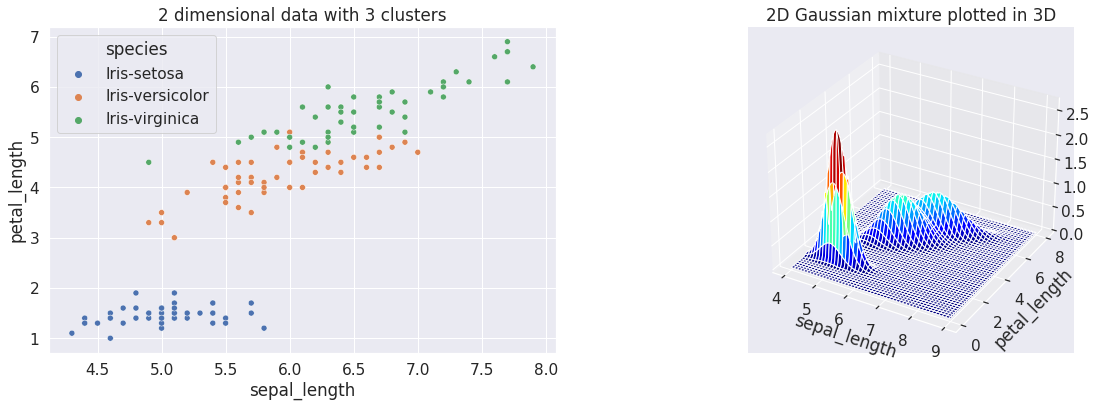

In [3]:
# Load in data
df_iris = pd.read_csv("../input/iris-flower-dataset/IRIS.csv")

# Select 2 features
df_iris = df_iris[['sepal_length','petal_length','species']]

# Scatterplot
fig = plt.figure(figsize=(20,6))
fig.add_subplot(121)
ax1 = sns.scatterplot(data=df_iris, x='sepal_length', y='petal_length', hue='species')
ax1.set_title('2 dimensional data with 3 clusters')

'''3D plot for 2D gaussian mixture estimation'''
# Define grid
x = np.linspace(4,9, num=100)
y = np.linspace(0,8, num=100)
x, y = np.meshgrid(x, y)
z = 0

# Estimate gaussian parameters
for flower in ['Iris-setosa','Iris-versicolor','Iris-virginica']:
    mu = df_iris[df_iris['species']==flower].iloc[:,:-1].mean()
    sigma = df_iris[df_iris['species']==flower].iloc[:,:-1].cov()
    z += multivariate_normal.pdf(np.dstack((x, y)), mu, sigma)

# Plot 3D plot with gaussian mixture estimate
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x,y,z, cmap=cm.jet)
ax2.set_title('2D Gaussian mixture plotted in 3D')
ax2.set_xlabel('sepal_length')
ax2.set_ylabel('petal_length')
plt.show()

The **inverse problem** this time, is this. Given the **density plot** on the right, and the fact that we're searching for 3 clusters, how do we decide which data points belong **together** (i.e. correspond to the same flower), and which ones don't. 

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.4 Sampling from a mixture</b></p>
</div>

To **sample** from a Gaussian mixture we can view this as a **two-step generative process**:
* Sample a random **class** index $C_i$ from the **categorical distribution** parameterised by $\pi=(\pi_1, \ldots, \pi_k)$.
* Then, sample a random **observation** $\textbf{X}_i$ from the corresponding **normal distribution** associated with class $C_i$.

Symbolically, we can represent this as

<center>
<img src="https://i.postimg.cc/m2Gp7MqZ/CXdistributions.png" width="180">
</center>

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.5 The inverse problem</b></p>
</div>

Now comes the exciting part. If we think that the data $X$ is distributed according to a **Gaussian mixture** with $k$ classes, how do we cluster this data so that we end up with $k$ normal distributions? That is, how do we estimate the **parameters** (means and covariances) of each of the $k$ normal distributions.

<hr>

**Scenario 1:**
If we **knew the class** that each data point belonged to, then we could **work out the parameters** of each normal distribution. This can be done by using formulas like this: (we'll formalise this later)

<center>
<img src="https://i.postimg.cc/Sx9K3Bdf/musigmaformula.png" width="300">
</center>

on a class-by-class basis ($\, j=1, \ldots, k$).

<hr>

**Scenario 2:**
If we **knew the parameters**, then we could **work out which class** each point should belong to. This can be done by using formulas like this: (we'll formalise this later)

$$
\mathbb{P}(C_j | x_i) = \frac{\mathbb{P}(x_i|C_j) \mathbb{P}(C_j)}{\sum_{t=1}^{k} \mathbb{P}(x_i|C_t) \mathbb{P}(C_t)}
$$

for each data point ($\, i=1, \ldots, n$).

<hr>

**The reality:**

Unfortunately, we are not quite in either of these scenarios but **if one was true**, then we would also be able to **perform the other one**. The solution to this **chicken and egg problem** is called the **Expectation-Maximisation (EM) algorithm**. 

<br>

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.5 EM algorithm at a glance</b></p>
</div>

The EM algorithm works in a **similar way to k-Means**. We start by selecting a **random** set of parameters for the $k$ gaussian distributions. This allows us to work out which class every point should belong to (scenario 2, called the **E-step**). The difference to k-Means however, is that EM performs a **soft assignment** (as opposed to a hard assignment). In k-Means, we label each data points as coming from one of the k classes, whereas in EM, we find the **probability** that each data point belongs to each of the $k$ classes. These probabilities are then used to **update** the Gaussian parameters (scenario 1, called the **M-step**). Finally, we **iterate to convergence**, always alternating between the E-step and the M-step.

# 4. Expectation-Maximisation algorithm

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.1 Example in 1D</b></p>
</div>

We'll start by building the **intuition** on how EM works by working through an example in 1 dimension. We will then formalise the general algorithm in d dimensions afterwards. 


Let's start with some **data** that we think has been generated by a **Gaussian mixture** with **k=2** classes in **1 dimension**.

<center>
<img src="https://i.postimg.cc/76W5fXTY/62420.jpg" width="700">
</center>

## Initialisation

The **first task** for the algorithm is to **randomly choose parameters** $\mu_1, \mu_2, \sigma_1^2, \sigma_2^2$ for the two normal distributions. We also need to choose some **weights** $\pi_1, \pi_2$, which tells us the **relative heights** of the curves. A good choice for the initial weights is $(\pi_1, \pi_2)=(0.5,0.5)$, i.e. the uniform distribution.

The resulting normal distributions might look something like this.
 
<center>
<img src="https://i.postimg.cc/9XgkQ988/20957.jpg" width="700">
</center>

## E-step

The **next step** (called the E-step) is to calculate how likely does each data point belong to each **class**. For example, consider the **rightmost point** on the diagram. Even though it is very **far from both** the green and orange distributions (and so is **unlikely** to have been generated from either of them), it is much **closer** to the green one. This means it is **more likely** to have been generated from the green distribution than the orange one, even if these probabilites are small. 

<hr>

**Bayes' formula** uses this idea of likelihood to find the probabilities we want:

$$
a_i = \mathbb{P}(C_1 | x_i) = \frac{\mathbb{P}(x_i|C_1) \mathbb{P}(C_1)}{\mathbb{P}(x_i|C_1) \mathbb{P}(C_1) + \mathbb{P}(x_i|C_2) \mathbb{P}(C_2)} = \frac{\mathbb{P}(x_i|C_1) \pi_1}{\mathbb{P}(x_i|C_1) \pi_1 + \mathbb{P}(x_i|C_2) \pi_2}
$$

where the **likelihood** is given by

$$
\mathbb{P}(x_i|C_1) = \frac{1}{\sqrt{2 \pi \sigma_1^2}} \exp \left(-\frac{(x_i-\mu_1)^2}{2 \sigma_1^2} \right)
$$

<hr>

Note that since there are only $k=2$ classes, we have $b_i = \mathbb{P}(C_2 | x_i) = 1 - \mathbb{P}(C_1 | x_i) = 1-a_i$. 

E.g. if $a_i = 0.99$ then $b_i = 0.01$. 

<hr>

So now we can think of the data points as being a **bit of orange** and a **bit of green** together. The exact proportion depends on the probabilities.

<center>
<img src="https://i.postimg.cc/X7LHZCYB/75482.jpg" width="700">
</center>

## M-step

Now we can **update the parameters** (called the M-step). Unlike in k-Means, which assigns classes using the **maximum** of these probabilites, GMMs use the **probabilities** to estimate the means and variances as weighted averages. 

For the **orange** distribution:

$$
\mu_1 = \frac{\sum_{i=1}^{n} a_i x_i}{\sum_{i=1}^{n} a_i}, \quad \sigma_1^2 = \frac{\sum_{i=1}^{n} a_i (x_i - \mu_1)^2}{\sum_{i=1}^{n} a_i}
$$

And for the **green** distribution:
$$
\mu_2 = \frac{\sum_{i=1}^{n} b_i x_i}{\sum_{i=1}^{n} b_i}, \quad \sigma_2^2 = \frac{\sum_{i=1}^{n} b_i (x_i - \mu_1)^2}{\sum_{i=1}^{n} b_i}
$$

These are just **weighted averages** of the usual formulas for mean and variance. The idea is that points **closest** to the distribution **contribute the most** to updating the correspoding parameters. 

<hr>

And we can't forget about updating the weights as well. This is done by **averaging** over the posterior probabilities:

$$
\pi_1 = \frac{\sum_{i=1}^{n} a_i}{n}, \quad \pi_2 = \frac{\sum_{i=1}^{n} b_i}{n} 
$$

You can think of this as calculating the **proportion** of the data that each cluster is describing. 

<hr>

And all that is left to do is to **iterate** until convergence! 

<center>
<img src="https://i.postimg.cc/HWXbnct0/67259.jpg" width="700">
</center>

<br>

<center>
<img src="https://i.postimg.cc/7Zs2dgx4/59430.jpg" width="700">
</center>

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.2 General case in d dimensions</b></p>
</div>

Now that you hopefully have the intuition behind GMMs, we are going to **generalise** the EM algorithm to **d dimensions** and **k clusters**. You will see that the equations are very similar, albeit more complicated, but their purpose is the same as before. 

<center>
<img src="https://c.tenor.com/i1rNMdaKd7MAAAAC/gaussian-mixture-models-em-method-math.gif" width="400">
</center>

## Initialisation

There are many options to initialise the means, covariance matrices and weights of the model. A **popular approach** (but not necessarily the best) is this. For each cluster k, choose the **mean** to be a **random data point** and the **covariance matrix** to be the **covariance of the dataset** $X$. The **weights** $\pi = (\pi_1, \ldots, \pi_k)$ are usually chosen to be **uniformly distributed**. 

Another approach worth mentioning is to use the output of the **k-Means algorithm** to initialise the parameters. The choice of initialisation can have **big impacts** on the resulting **clusters**, so it is worth experimenting with different techniques. 

## E-step


The posterior probabilities this time are called **responsibilities**, $r_{ij}$, of the $j$-th mixture component for data point $x_i$. These generalise the quantities $a_i$ and $b_i$ we saw earlier.

$$
r_{ij} = \mathbb{P}(C_j | x_i) = \frac{\mathbb{P}(x_i|C_j) \mathbb{P}(C_j)}{\sum_{t=1}^{k} \mathbb{P}(x_i|C_t) \mathbb{P}(C_t)} = \frac{\mathbb{P}(x_i|C_j) \pi_j}{\sum_{t=1}^{k} \mathbb{P}(x_i|C_t) \pi_t}
$$

## M-step

Unlike in **gradient descent**, which performs **small improvements** towards the direction of the optimum solution, the **EM algorithm** jumps straight the **best solution** available at each step. It's for this reason the algorithm can **converge** in only a few number of steps but it also means that the **starting conditions** have a huge impact on the result. 

We estimate the **mean** and **covariances** of each class as follows:

$$
{\boldsymbol \mu}_j = \frac{\sum_{i=1}^n r_{ij} \textbf{x}_{i}}{n_j}, \qquad {\boldsymbol \Sigma}_j = \frac{1}{n_j} \sum_{i=1}^{n} r_{ij} (\textbf{x}_i - {\boldsymbol \mu}_j) (\textbf{x}_i - {\boldsymbol \mu}_j)^{T}
$$

where $n_j = \sum_{i=1}^{n} r_{ij}$ is defined as the **total responsibility** of the j-th mixture component.

These generalise our earlier formulas. Remember, they are just **weighted averges** of the usual mean and covariance formulas. Points closest to each cluster have the biggest **impact** on updating the corresponding Gaussian parameters.
<hr>

Finally, we update the **mixture weights** to be

$$
\pi_j = \frac{n_j}{n}.
$$

Think of this as the **proportion of the total responsibility** associated with the $j$-th mixture. 

<hr>

And **that's it**! Surprisingly, the EM-algorithm needs just a **handful of equations** to be implemented. We'll do this next.

# 5. Implementation

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>5.1 GMM</b></p>
</div> 

I adapted the code from this blog: [ML From Scratch, Part 5: Gaussian Mixture Models](http://www.oranlooney.com/post/ml-from-scratch-part-5-gmm/).

In [4]:
class GMM:
    def __init__(self, k, max_iter=100, random_state = 0):
        self.k = k
        self.max_iter = max_iter
        self.random_state = random_state

    def initialise(self, X):
        self.shape = X.shape
        self.n, self.d = self.shape
        
        self.pi = np.full(shape=self.k, fill_value=1/self.k)
        self.responsibilities = np.full(shape=self.shape, fill_value=1/self.k)
        
        np.random.seed(self.random_state)
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [X[row_index,:] for row_index in random_row]
        self.sigma = [np.cov(X.T) for _ in range(self.k)]

    def E_step(self, X):
        # E-Step: update the responsibilities by holding mu and sigma constant
        self.responsibilities = self.predict_proba(X)
    
    def M_step(self, X):
        # M-Step: update pi, mu and sigma by holding responsibilities constant
        self.pi = self.responsibilities.mean(axis=0)
        for j in range(self.k):
            r_column = self.responsibilities[:,j]
            total_responsibility = r_column.sum()
            self.mu[j] = (X * r_column[:, np.newaxis]).sum(axis=0)/total_responsibility
            self.sigma[j] = np.cov(X.T, aweights=(r_column/total_responsibility).flatten(), bias=True)

    def fit(self, X):
        self.initialise(X)
        
        for iteration in range(self.max_iter):
            self.E_step(X)
            self.M_step(X)
    
    def predict_proba(self, X):
        likelihood = np.zeros((self.n, self.k))
        for j in range(self.k):
            distribution = multivariate_normal(mean=self.mu[j], cov=self.sigma[j])
            likelihood[:,j] = distribution.pdf(X)
        
        numerator = likelihood * self.pi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        responsibilities = numerator / denominator
        return responsibilities
    
    def predict(self, X):
        responsibilities = self.predict_proba(X)
        return np.argmax(responsibilities, axis=1)
    
    def fit_predict(self, X):
        self.fit(X)
        predictions = self.predict(X)
        return predictions

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>5.2 Application</b></p>
</div> 

Let's take our new model for a spin. We will apply it to this months TPS competition which is on **unsupervised clustering**. You can find my detailed analysis on the dataset in my notebook here: [TPS July 22 - Unsupervised clustering](https://www.kaggle.com/code/samuelcortinhas/tps-july-22-unsupervised-clustering).

The dataset is made up of **29 features** and **98,000** data points and the task is to **cluster the data**.

In [5]:
# Load data
data=pd.read_csv('../input/tabular-playground-series-jul-2022/data.csv', index_col='id')

# Preprocess data
scaled_data = pd.DataFrame(PowerTransformer().fit_transform(data))
scaled_data.columns = data.columns
drop_feats = [f'f_0{i}' for i in range(7)]
drop_feats = drop_feats + [f'f_{i}' for i in range(14,22)]
X = scaled_data.drop(drop_feats, axis=1).values

In [6]:
%%time

# Gaussian Mixture Model
gmm = GMM(k=7, max_iter=100)
preds = gmm.fit_predict(X)

CPU times: user 1min 43s, sys: 1min 27s, total: 3min 11s
Wall time: 48.9 s


<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>5.3 Visualise predictions</b></p>
</div> 

**Label distribution**

Text(0.5, 1.0, 'Predicted clusters')

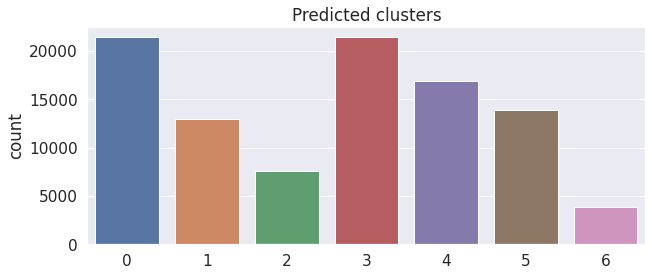

In [7]:
# Countplot
plt.figure(figsize=(10,4))
sns.countplot(x=preds)
plt.title('Predicted clusters')

**Cluster distributions**

We know (from my other notebook) that the continuous features are **gaussian mixtures**. We can check to see if the clusters are normally distributed over each feature as they should be.

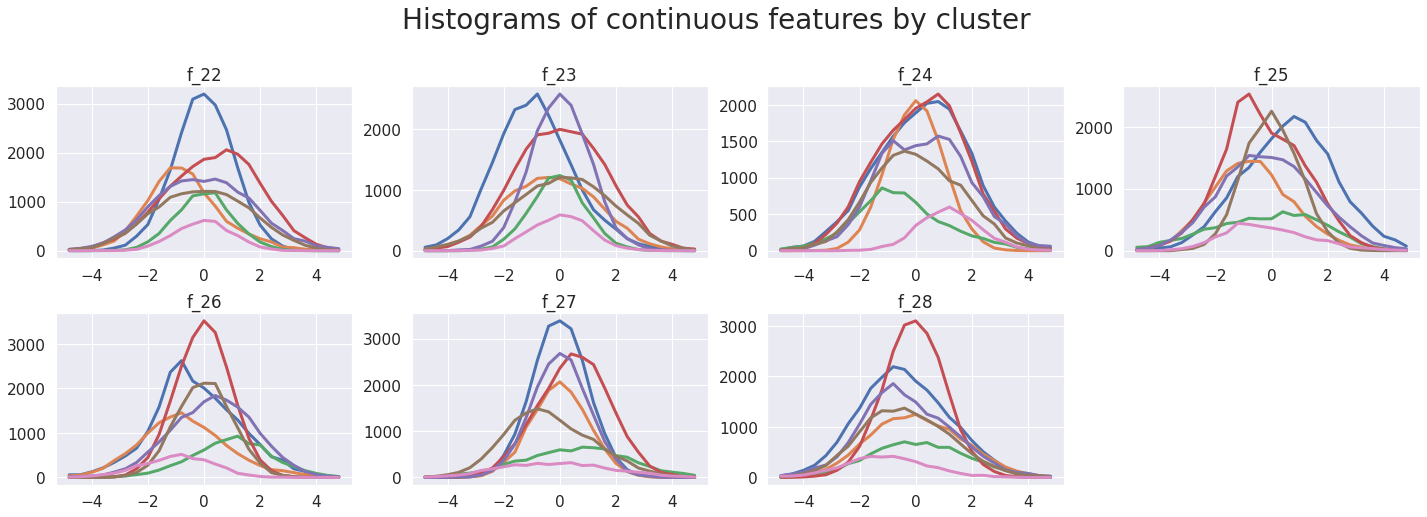

In [8]:
# From https://www.kaggle.com/code/ambrosm/tpsjul22-gaussian-mixture-cluster-analysis
fig, axs = plt.subplots(2, 4, figsize=(20, 7))
axs = axs.ravel()
float_columns = ['f_22','f_23','f_24','f_25','f_26','f_27','f_28']
y=preds
for ax, f in zip(axs, float_columns):
    for i in range(7):
        h, edges = np.histogram(data[f][y == i], bins=np.linspace(-5, 5, 26))
        ax.plot((edges[:-1] + edges[1:]) / 2, h, label=f"Cluster {i}", lw=3)
    ax.set_title(f)
#axs[-2].axis('off')
axs[-1].axis('off')
plt.suptitle('Histograms of continuous features by cluster', y=1.02, fontsize=28)
fig.tight_layout(h_pad=1.0, w_pad=0.5)
plt.show()

**PCA**

Principle Component Analysis

In [9]:
%%time

# PCA
pca = PCA(n_components=3)
components = pca.fit_transform(X)

# 3D scatterplot
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=preds, size=0.1*np.ones(len(X)), opacity = 1,
    title='PCA plot in 3D',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width=650, height=500
)
fig.show()

CPU times: user 1.68 s, sys: 955 ms, total: 2.64 s
Wall time: 2.11 s


<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>5.4 Submit predictions</b></p>
</div> 

Competition **public leaderboard** score: (higher is better)
* My GMM: 0.54838
* sklearn's GMM: 0.49625

In [10]:
sub = pd.read_csv('../input/tabular-playground-series-jul-2022/sample_submission.csv')
sub['Predicted'] = preds
sub.to_csv('submission.csv', index=False)

It seems that our random initialisation produced **better results** than sklearn's version, which uses the output of a k-Means run to initialise the parameters.

# 6. Conclusion

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>6.1 Strengths</b></p>
</div> 

GMM is a popular clustering algorithm for the following reasons:

* **Fast** - it's the fastest algorithm for learning mixture models
* **Adaptable** - can handle a greater variety of shapes than k-Means
* **Soft classification** - can provide the probability that each point belongs to a particular cluster

<div style="color:white;display:fill;
            background-color:#4577ff;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>6.2 Limitations</b></p>
</div> 

Some of the drawbacks of GMMs include:

* **Number of components** - you have to choose this manualy beforehand
* **Singularities** - some mixtures can 'die out' if there are no points nearby. This can lead to problems computing the covariance matrices. 

#  7. References 

The two **videos** by Victor Lavrenko were great for building my **intuition** and I recommend you watch them too. The **book** contained all the correct **equations** and their derivation. The **articles** were most helpful in writting the **code**.

* [Video: EM algorithm: how it works](https://www.youtube.com/watch?v=REypj2sy_5U&ab_channel=VictorLavrenko) by Victor Lavrenko.
* [Video: Expectation Maximization: how it works](https://www.youtube.com/watch?v=iQoXFmbXRJA&ab_channel=VictorLavrenko) by Victor Lavrenko.
* [Article: Gaussian Mixture Models:
implemented from scratch](https://towardsdatascience.com/gaussian-mixture-models-implemented-from-scratch-1857e40ea566) by Vasile Păpăluță.
* [Book: Mathematics for Machine Learning](https://mml-book.github.io/book/mml-book.pdf) by Deisenroth, Faidal and Ong, 2020. 
* [Article: ML From Scratch, Part 5: Gaussian Mixture Models](http://www.oranlooney.com/post/ml-from-scratch-part-5-gmm/) by Oran Looney.
* [Article: Expectation-Maximization for GMMs explained](https://towardsdatascience.com/expectation-maximization-for-gmms-explained-5636161577ca) by Maël Fabien.
* [Notebook: TPS July 22 - Unsupervised clustering](https://www.kaggle.com/code/samuelcortinhas/tps-july-22-unsupervised-clustering) by [Samuel Cortinhas](https://www.kaggle.com/samuelcortinhas).